In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#1. Preparing the data (do not execute if already executed before)

In [ ]:
%cd 'gdrive/MyDrive'

/content/gdrive/MyDrive


In [ ]:
from os import mkdir
!mkdir plantdoc_frcnn

In [ ]:
%cd plantdoc_frcnn/

/content/gdrive/MyDrive/plantdoc_frcnn


In [ ]:
!git clone https://github.com/ILAN-Solutions/leaf-disease-using-faster-rcnn.git keras-frcnn_corrected


Cloning into 'keras-frcnn_corrected'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 59 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [ ]:
!git clone https://github.com/pratikkayal/PlantDoc-Object-Detection-Dataset.git Data

Cloning into 'Data'...
remote: Enumerating objects: 5190, done.
remote: Total 5190 (delta 0), reused 0 (delta 0), pack-reused 5190
Receiving objects: 100% (5190/5190), 941.89 MiB | 41.93 MiB/s, done.
Resolving deltas: 100% (2328/2328), done.
Checking out files: 100% (5199/5199), done.


In [ ]:
import shutil
shutil.move("Data/TRAIN", "gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected") 

'gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected/TRAIN'

In [ ]:
import shutil
shutil.move("Data/TEST", "gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected") 

'gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected/TEST'

Our data is in the Pascal VOC XML format, we convert it to a csv format

In [ ]:
%cd /content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected

/content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected


In [34]:
import glob
import pandas as pd
import xml.etree.ElementTree as ET
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(member.find('bndbox').find('xmin').text),
                     int(member.find('bndbox').find('xmax').text),
                     int(member.find('bndbox').find('ymin').text),
                     int(member.find('bndbox').find('ymax').text),
                     member.find('name').text
                     )
            xml_list.append(value)
    column_name = ['filename','xmin', 'xmax', 'ymin', 'ymax','class_name']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


In [35]:
train=xml_to_csv('TRAIN')

In [36]:
test=xml_to_csv('TEST')

In [37]:
train.head()

,filename,xmin,xmax,ymin,ymax,class_name
0,corn-mature-bacterial-leaf-streak.jpg,96,630,4,1200,Corn leaf blight
1,lb2.jpg,226,601,3,298,Tomato leaf late blight
2,lb2.jpg,245,698,267,596,Tomato leaf late blight
3,lb2.jpg,81,421,2,450,Tomato leaf late blight
4,dusty-mildew-on-plants-downy-mildew-zucchini-p...,32,487,8,375,Squash Powdery mildew leaf


##Some data viz

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches

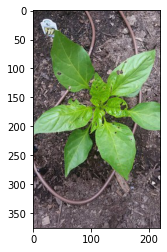

In [31]:
# reading single image using imread function of matplotlib
image = plt.imread('TRAIN/0.jpg')
plt.imshow(image)


In [ ]:
train['class_name'].value_counts()

Blueberry leaf                          827
Tomato leaf yellow virus                787
Peach leaf                              610
Raspberry leaf                          539
Strawberry leaf                         462
Tomato Septoria leaf spot               412
Tomato leaf                             369
Corn leaf blight                        360
Potato leaf early blight                316
Bell_pepper leaf                        312
Tomato mold leaf                        277
Tomato leaf bacterial spot              266
Squash Powdery mildew leaf              251
Bell_pepper leaf spot                   249
Soyabean leaf                           246
Potato leaf late blight                 240
Apple leaf                              237
Tomato leaf mosaic virus                225
Cherry leaf                             221
Tomato leaf late blight                 207
grape leaf                              205
Tomato Early blight leaf                195
Apple rust leaf                 

Bell_pepper leaf spot
Bell_pepper leaf spot
Bell_pepper leaf spot
Bell_pepper leaf spot
Bell_pepper leaf spot
Bell_pepper leaf spot


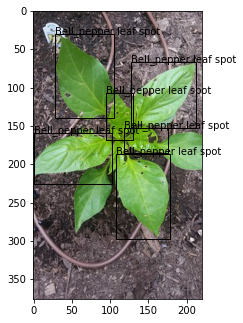

In [39]:
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('TRAIN/0.jpg')
plt.imshow(image)

# iterating over the image for different objects
for i,row in train[train.filename == "0.jpg"].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    print(row['class_name'])
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, facecolor=None,fill=False,label=row['class_name'])
    
    ax.add_patch(rect)
    ax.text(xmin,ymin,row['class_name'])

##Creating annotate.txt file that will be passed into the model

In [40]:
data = pd.DataFrame()
data['format'] = train['filename']

# as the images are in train_images folder, add train_images before the image name
for i in range(data.shape[0]):
    data['format'][i] = '/content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected/TRAIN/' + data['format'][i]

# add xmin, ymin, xmax, ymax and class as per the format required
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(train['xmin'][i]) + ',' + str(train['xmax'][i]) + ',' + str(train['ymin'][i]) + ',' + str(train['ymax'][i])  + ',' + str(train['class_name'][i])

data.to_csv('/content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected/annotate.txt', header=None, index=None, sep=' ')

#2. Faster RCNN

In [41]:
%cd /content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected

/content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected


In [ ]:
!pip install -r /content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected/requirements.txt

     |████████████████████████████████| 196 kB 5.2 MB/s 
     |████████████████████████████████| 2.8 MB 41.6 MB/s 
  Created wheel for Keras: filename=Keras-2.0.3-py3-none-any.whl size=232959 sha256=1a4442590c434af84d105b8c2b913f76dd07252bc37606a9da807508a6bdc416
  Stored in directory: /root/.cache/pip/wheels/7d/40/7d/6b95f24cb13373df91040f04dd0c9e4e70a654c3c7aa6970e4
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=2a9791e7b3f56973d2014f5d4741f31fdd62f92f7499ea5ed3a7900707905d34
  Stored in directory: /root/.cache/pip/wheels/26/68/6f/745330367ce7822fe0cd863712858151f5723a0a5e322cc144
Successfully built Keras theano
  Attempting uninstall: Keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.

In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall


     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 15.7 MB 179 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.
tensorflow 2.6.0 requires keras~=2.6, but you have keras 2.0.3 which is incompatible.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
tensorflo

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!python train_frcnn.py -o simple -p annotate.txt --num_epochs 10

Using TensorFlow backend.
Parsing annotation files
Training images per class:
{'Apple Scab Leaf': 158,
 'Apple leaf': 236,
 'Apple rust leaf': 168,
 'Bell_pepper leaf': 312,
 'Bell_pepper leaf spot': 249,
 'Blueberry leaf': 823,
 'Cherry leaf': 221,
 'Corn Gray leaf spot': 75,
 'Corn leaf blight': 358,
 'Corn rust leaf': 117,
 'Peach leaf': 610,
 'Potato leaf': 11,
 'Potato leaf early blight': 310,
 'Potato leaf late blight': 240,
 'Raspberry leaf': 539,
 'Soyabean leaf': 246,
 'Squash Powdery mildew leaf': 248,
 'Strawberry leaf': 462,
 'Tomato Early blight leaf': 195,
 'Tomato Septoria leaf spot': 412,
 'Tomato leaf': 369,
 'Tomato leaf bacterial spot': 266,
 'Tomato leaf late blight': 207,
 'Tomato leaf mosaic virus': 225,
 'Tomato leaf yellow virus': 768,
 'Tomato mold leaf': 277,
 'Tomato two spotted spider mites leaf': 2,
 'bg': 0,
 'grape leaf': 205,
 'grape leaf black rot': 125}
Num classes (including bg) = 30
Config has been written to config.pickle, and can be loaded when tes

#3. Preprocessing of test data

In [ ]:
%cd /content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected

/content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected


In [ ]:
test=xml_to_csv('/content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected/TEST')

In [ ]:
data = pd.DataFrame()
data['format'] = test['filename']

# as the images are in test_images folder, add train_images before the image name
for i in range(data.shape[0]):
    data['format'][i] = '/content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected/TEST/' + data['format'][i]

# add xmin, ymin, xmax, ymax and class as per the format required
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(test['xmin'][i]) + ',' + str(test['xmax'][i]) + ',' + str(test['ymin'][i]) + ',' + str(test['ymax'][i] ) + ',' + str(test['class_name'][i]) 

data.to_csv('/content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected/test.txt', header=None, index=None, sep=' ')

#3. Testing

In [ ]:
!pip install -r /content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected/requirements.txt

  Using cached Keras-2.0.3-py3-none-any.whl
  Attempting uninstall: Keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall


     |████████████████████████████████| 2.9 MB 4.0 MB/s 
     |████████████████████████████████| 15.7 MB 186 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
lucid 0.3.10 requires numpy<=1.19, but you have numpy 1.21.2 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, but

In [ ]:
%cd /content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected

/content/gdrive/MyDrive/plantdoc_frcnn/keras-frcnn_corrected


In [ ]:
pwd

'/content/gdrive/My Drive/plantdoc_frcnn/keras-frcnn_corrected'

In [ ]:
<!python measure_map.py -o simple -p test.txt


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Peach leaf AP: 1.0
Apple rust leaf AP: 1.0
Corn leaf blight AP: 1.0
Tomato Early blight leaf AP: 1.0
grape leaf black rot AP: 1.0
Apple Scab Leaf AP: 1.0
Corn rust leaf AP: 1.0
Soyabean leaf AP: 1.0
Strawberry leaf AP: nan
Bell_pepper leaf AP: 1.0
Tomato leaf yellow virus AP: 1.0
Tomato leaf late blight AP: 1.0
Potato leaf late blight AP: 1.0
Tomato leaf AP: 1.0
Squash Powdery mildew leaf AP: nan
Potato leaf early blight AP: 1.0
Tomato mold leaf AP: 1.0
mAP = nan
63/236
Elapsed time = 11.272489786148071
Tomato leaf bacterial spot AP: 1.0
Tomato Septoria leaf spot AP: 1.0
Bell_pepper leaf spot AP: 1.0
Apple leaf AP: 0.7714285714285716
grape leaf AP: 1.0
Peach leaf AP: 1.0
Apple rust leaf AP: 1.0
Corn leaf blight AP: 1.0
Tomato Early blight leaf AP: 1.0
grape leaf black rot AP: 1.0
Apple Scab Leaf AP: 1.0
Corn rust leaf AP: 1.0
Soyabean leaf AP: 1.0
Strawberry leaf AP: nan
Bell_pepper leaf AP: 1.0
Tomato leaf y

In [ ]:
!python test_frcnn.py -p TEST

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
   1.67450085e-02 9.80491098e-03 2.88293771e-02 1.83832292e-02
   2.50355573e-03 1.87321156e-02 9.99689009e-03 5.70472423e-03
   6.53198408e-03 1.59273855e-02 1.78925246e-02 1.14544368e-04
   2.33706800e-04 6.53240144e-01]
  [1.70868495e-03 2.49502040e-03 6.43833657e-04 8.84922687e-03
   4.16421099e-04 4.86414693e-03 9.06619802e-03 3.73388221e-03
   4.10726247e-03 2.17560097e-03 6.35980582e-03 1.51002023e-03
   3.34602635e-04 2.03371653e-03 2.05056253e-03 7.09991576e-03
   4.72099893e-03 5.78531763e-03 3.62501969e-03 3.82677815e-03
   9.21519415e-04 3.26998904e-03 3.68451863e-03 3.09158489e-03
   2.07099784e-03 6.99835224e-03 4.06710524e-03 7.59609566e-06
   3.11362674e-05 9.00450230e-01]
  [1.11057414e-02 1.30256610e-02 5.43750823e-03 3.39730680e-02
   4.07488132e-03 2.18925551e-02 3.86007242e-02 1.84829868e-02
   1.79603379e-02 1.56095512e-02 3.84485312e-02 1.53942723e-02
   3.67639586e-03 1.01802219e-02 1.